# Examining Volunteer internal consistency

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
import numpy as np
import pandas as pd
import lib.galaxy_utilities as gu
from functools import partial
import matplotlib.pyplot as plt

In [3]:
dr8ids, ss_ids, validation_ids = np.load('lib/duplicate_galaxies.npy').T

In [4]:
gzb_models = pd.read_pickle('galaxy-builder-aggregate-models.pickle')

In [6]:
def get_annotations(sid):
    return gu.classifications.query(
        'subject_ids == {}'.format(sid)
    )['annotations'].apply(json.loads)

In [7]:
def n_drawn_comps(a, task=0):
    try:
        return len(a[task]['value'][0]['value'])
    except IndexError:
        return np.nan

def get_details(ann0, ann1, task=0):
    n_drawn0 = ann0.apply(partial(n_drawn_comps, task=task))
    n_drawn1 = ann1.apply(partial(n_drawn_comps, task=task))
    return sum(((s.mean(), s.std()) for s in (n_drawn0, n_drawn1)), ())

def get_disk_details(ann0, ann1):
    return get_details(ann0, ann1, task=0)

def get_bulge_details(ann0, ann1):
    return get_details(ann0, ann1, task=1)

def get_bar_details(ann0, ann1):
    return get_details(ann0, ann1, task=2)

def get_spiral_arm_details(ann0, ann1):
    return get_details(ann0, ann1, task=3)

In [13]:
out = []
columns = [
    '{}-{}-{}'.format(s, k, v) 
    for k in ('disk', 'bulge', 'bar', 'spiral_arms')
    for s in ('original', 'validation')
    for v in ('mean', 'std')
]
for i in range(len(dr8ids)):
    id_details = {
        'original_id': ss_ids[i],
        'validation_id': validation_ids[i],
        'dr8id': dr8ids[i],
    }
    details = np.array([
        get_details(
            get_annotations(ss_ids[i]),
            get_annotations(validation_ids[i]),
            task=j
        )
        for j in range(4)
    ])
    freq_details = {k: v for k, v in zip(columns, details.reshape(-1))}
    out.append({**id_details, **freq_details})

In [14]:
df = pd.DataFrame(out)

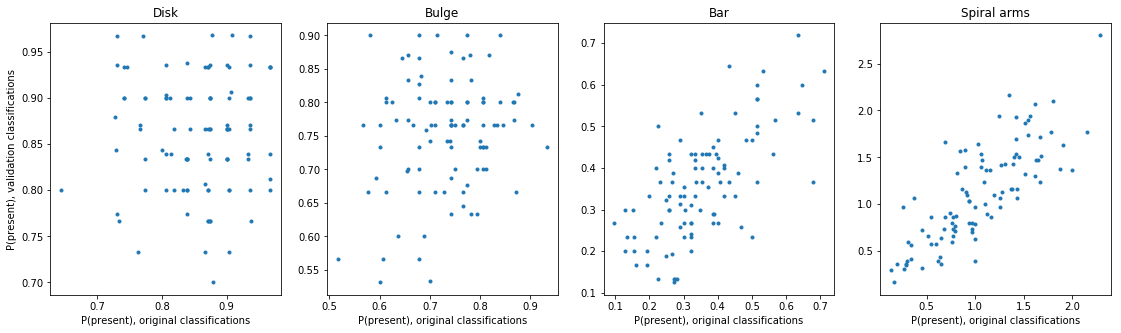

In [16]:
fig, (ax_disk, ax_bulge, ax_bar, ax_spiral) = plt.subplots(ncols=4, figsize=(19, 5))
ax_disk.plot(df['original-disk-mean'], df['validation-disk-mean'], '.')
ax_bulge.plot(df['original-bulge-mean'], df['validation-bulge-mean'], '.')
ax_bar.plot(df['original-bar-mean'], df['validation-bar-mean'], '.')
ax_spiral.plot(df['original-spiral_arms-mean'], df['validation-spiral_arms-mean'], '.')
ax_disk.set_title('Disk'); ax_bulge.set_title('Bulge')
ax_bar.set_title('Bar'); ax_spiral.set_title('Spiral arms')
for ax in (ax_disk, ax_bulge, ax_bar, ax_spiral):
    ax.set_xlabel('P(present), original classifications')
ax_disk.set_ylabel('P(present), validation classifications');

In [11]:
def get_n_spirals_in_model(sid):
    return len([
        f for f in os.listdir('lib/spiral_arms')
        if re.match(r'{}-[0-9]+\.pickle'.format(sid), f)
    ])
n_spirals_original = np.fromiter(map(get_n_spirals_in_model, ss_ids), dtype=int)
n_spirals_validation = np.fromiter(map(get_n_spirals_in_model, validation_ids), dtype=int)

In [12]:
sum(np.abs(n_spirals_original - n_spirals_validation) < 1) / len(n_spirals_validation)

0.673469387755102

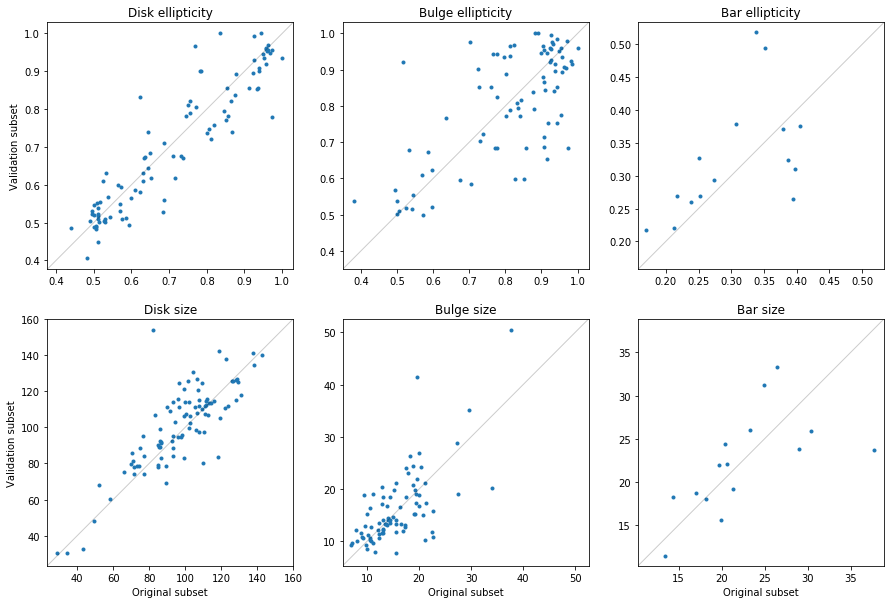

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax_disk, ax_bulge, ax_bar = np.array(axes).T
# Disk
ax = ax_disk
ax[0].plot(
    gzb_models.loc[ss_ids]['disk-axRatio'],
    gzb_models.loc[validation_ids]['disk-axRatio'],
    '.'
)
ax[1].plot(
    gzb_models.loc[ss_ids]['disk-rEff'],
    gzb_models.loc[validation_ids]['disk-rEff'],
    '.'
)
ax[0].set_title('Disk ellipticity')
ax[1].set_title('Disk size')
for a in ax:
    a.set_ylabel('Validation subset');
ax[1].set_xlabel('Original subset')

ax = ax_bulge
ax[0].plot(
    gzb_models.loc[ss_ids]['bulge-axRatio'],
    gzb_models.loc[validation_ids]['bulge-axRatio'],
    '.'
)
ax[1].plot(
    gzb_models.loc[ss_ids]['bulge-rEff'],
    gzb_models.loc[validation_ids]['bulge-rEff'],
    '.'
)
ax[0].set_title('Bulge ellipticity')
ax[1].set_title('Bulge size')
ax[1].set_xlabel('Original subset')

# Bar
ax = ax_bar
ax[0].plot(
    gzb_models.loc[ss_ids]['bar-axRatio'],
    gzb_models.loc[validation_ids]['bar-axRatio'],
    '.'
)
ax[1].plot(
    gzb_models.loc[ss_ids]['bar-rEff'],
    gzb_models.loc[validation_ids]['bar-rEff'],
    '.'
)
ax[0].set_title('Bar ellipticity')
ax[1].set_title('Bar size')
ax[1].set_xlabel('Original subset')

for ax in (ax_disk, ax_bulge, ax_bar):
    for a in ax:
        l = a.get_xlim() + a.get_ylim()
        lims = min(l), max(l)
        a.plot((-1e3, 1e3), (-1e3, 1e3), 'k', alpha=0.2, linewidth=1)
        a.set_xlim(lims); a.set_ylim(lims)

plt.savefig('duplicates_plots/component_sizing.pdf', bbox_inches='tight')

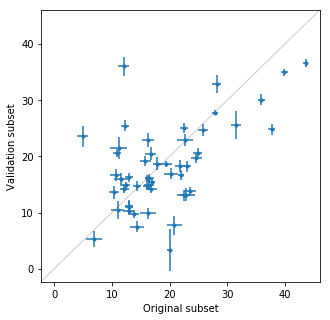

In [53]:
from gzbuilderspirals.oo import Arm
def get_pa(sid):
    arms = [
        Arm.load(os.path.join('lib/spiral_arms', f))
        for f in os.listdir('lib/spiral_arms')
        if re.match(r'{}-[0-9]+\.pickle'.format(sid), f)
    ]
    if not len(arms) > 0:
        return np.nan, np.nan
    p = arms[0].get_parent()
    return p.get_pitch_angle(arms)

pa_original = np.array(list(map(get_pa, ss_ids)))
pa_validation = np.array(list(map(get_pa, validation_ids)))

plt.figure(figsize=(5, 5))
plt.errorbar(
    pa_original[:, 0], pa_validation[:, 0],
    xerr=pa_original[:, 1], yerr=pa_validation[:, 1],
    fmt='.'
)
l = plt.xlim() + plt.ylim()
lims = min(l), max(l)
plt.plot((-90, 90), (-90, 90), 'k', alpha=0.2, linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Original subset')
plt.ylabel('Validation subset');